In [1]:
## import libraries for the analysis
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##import modules from other folders
import sys
sys.path.insert(0, 'C:/Users/neuroPC/Documents/GitHub/utilities')
from useful_tools import select_animals_gpt
from data_cleaning import preprocess_fictrac_data
sys.path.insert(0, 'C:/Users/neuroPC/Documents/GitHub/bonfic')
from analyse_stimulus_evoked_response import main

Transition indices: [2 4 7]


Session 0.1: Load analysis methods in python dictionary form

In [2]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
sheet_name="Zball"
Datasets="Z:/DATA/experiment_trackball_Optomotor"
thisDataset = f"{Datasets}/{sheet_name}"

Session 0.2: check methods to use and whether some methods should be updated

In [3]:
analysis_methods

{'experimenter': 'chiyu',
 'sorter_name': 'kilosort4',
 'analyse_good_channels_only': False,
 'load_raw_traces': False,
 'analyse_entire_recording': True,
 'include_MUA': True,
 'save_prepocessed_file': False,
 'load_prepocessed_file': True,
 'save_sorting_file': False,
 'load_sorting_file': True,
 'save_analyser_to_disc': True,
 'load_analyser_from_disc': False,
 'extract_waveform_sparse': False,
 'extract_waveform_sparse_explicit': False,
 'export_to_phy': True,
 'overwrite_existing_phy': True,
 'load_curated_spikes': True,
 'export_report': False,
 'event_of_interest': 'stim_onset',
 'analyse_stim_evoked_activity': True,
 'experiment_name': 'coherence',
 'overwrite_curated_dataset': True,
 'graph_colour_code': ['r', 'y', 'm', 'c', 'k', 'b', 'g', 'r'],
 'debug_mode': False,
 'fictrac_posthoc_analysis': True,
 'use_led_to_align_stimulus_timing': True,
 'isi_onset_log': True,
 'filtering_method': 'sg_filter',
 'plotting_tbt_overview': True,
 'plotting_trajectory': True,
 'plotting_even

Session 0.3: Load animal directory as a list

In [4]:
## this cell searches for a folder with a specified experiment_name under the dataset path and list up all the csv file in that folder.
## In this project, we usually have one csv file in that folder so there is no confusion
dir_list = []
file_type=".dat"
for root, dirs, files in os.walk(thisDataset):
    if analysis_methods.get("experiment_name") in root.split(
        os.path.sep
    ):  ## add this condition to avoid data from other experiments
        for folder in dirs:
            if folder.startswith("session"):
                folder_path=os.path.join(root,folder)
                if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                    dir_list.append(folder_path.replace("\\", "/"))


print(f"these directories are found {dir_list}")

these directories are found ['Z:/DATA/experiment_trackball_Optomotor/Zball/GN23001/231121/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23001/231121/coherence/session2', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23002/231121/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23002/231121/coherence/session2', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23003/231122/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23003/231122/coherence/session2', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23004/231122/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23004/231122/coherence/session2', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23005/231123/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23005/231123/coherence/session2', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23006/231123/coherence/session1', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23006/231123/coherenc

In [5]:
dir_list

['Z:/DATA/experiment_trackball_Optomotor/Zball/GN23001/231121/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23001/231121/coherence/session2',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23002/231121/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23002/231121/coherence/session2',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23003/231122/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23003/231122/coherence/session2',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23004/231122/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23004/231122/coherence/session2',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23005/231123/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23005/231123/coherence/session2',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23006/231123/coherence/session1',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23006/231123/coherence/session2',
 'Z:

In [ ]:
def find_session_folders(base_directory, file_type, paradigm_name):
    session_folders = []

    for root, dirs, files in os.walk(base_directory):
        # Check if the target folder (e.g., 'apple') is in the root path and the paradigm name is in the root path
        if paradigm_name in root.split(os.path.sep):
            for folder in dirs:
                # Check if the folder name starts with 'session'
                if folder.startswith("session"):
                    folder_path = os.path.join(root, folder)
                    # Check if the folder contains at least one file with the specified file type
                    if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                        session_folders.append(folder_path)

    return session_folders



In [ ]:
base_directory = thisDataset
file_type = ".dat"
paradigm_name = analysis_methods.get("experiment_name")

session_folders = find_session_folders(base_directory, file_type, paradigm_name)

print(f"These directories are found: {session_folders}")

In [ ]:
dir_list

Session 1.0: Create fictrac curated dataset based on the list of directories

In [ ]:
# because the import does not update the new version of python.
# Need to restart kernel 
for this_dir in dir_list:
    if "database_curated.pickle" in os.listdir(this_dir):
        print(f"curated fictrac data found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated fictrac data in {this_dir}. Create curated file")
        preprocess_fictrac_data(dir_list)


Session 1.5: load particular animals into directory list for further analysis

In [ ]:
# Define the path to your Excel file
dir_list = []
file_type=".pickle"
using_google_sheet=True
sheet_name = "VCCball"
experiment_name=analysis_methods.get("experiment_name")
if analysis_methods.get("load_experiment_condition_from_database") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file

        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Experimenter","NS")
        #print(animal_of_interest)
    else:
        animal_of_interest=df
    ID_array=animal_of_interest["ID"].values
    dir_list = [
    root.replace("\\", "/")
    for root, dirs, files in os.walk(thisDataset)
    if any(ID in root for ID in ID_array)
    and experiment_name in root.split(os.path.sep)
    and any(name.endswith(file_type) for name in files)


    
]
else:
    ## this cell searches for a folder with a specified experiment_name under the dataset path and list up all the hdf5 file in that folder.
    ## However,some changes need to be made once we do sleap or deeplabcut where there are more than one H5 file generated
    for root, dirs, files in os.walk(thisDataset):
        if analysis_methods.get("experiment_name") in root.split(os.path.sep):## add this condition to avoid data from other experiments
            for folder in dirs:
                if folder.startswith("session"):
                    folder_path = os.path.join(root, folder)
                    # Check if the folder contains at least one file with the specified file type
                    if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                        session_folders.append(folder_path)

Session 2.1: analyse individual animal's optomotor response with curated fictrac tracking

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session2. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session2. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session2. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session2. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23011\231125\coherence\session2\fictrac2023-11-25T18_49_22.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


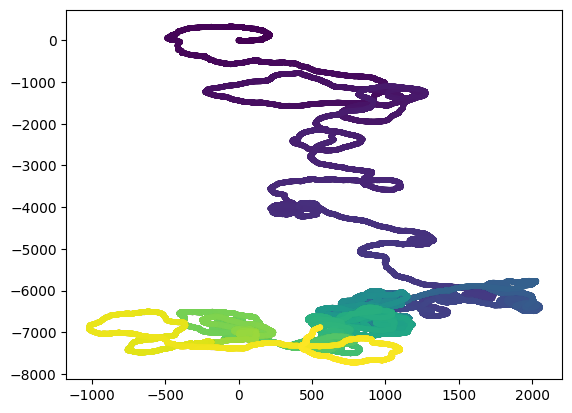

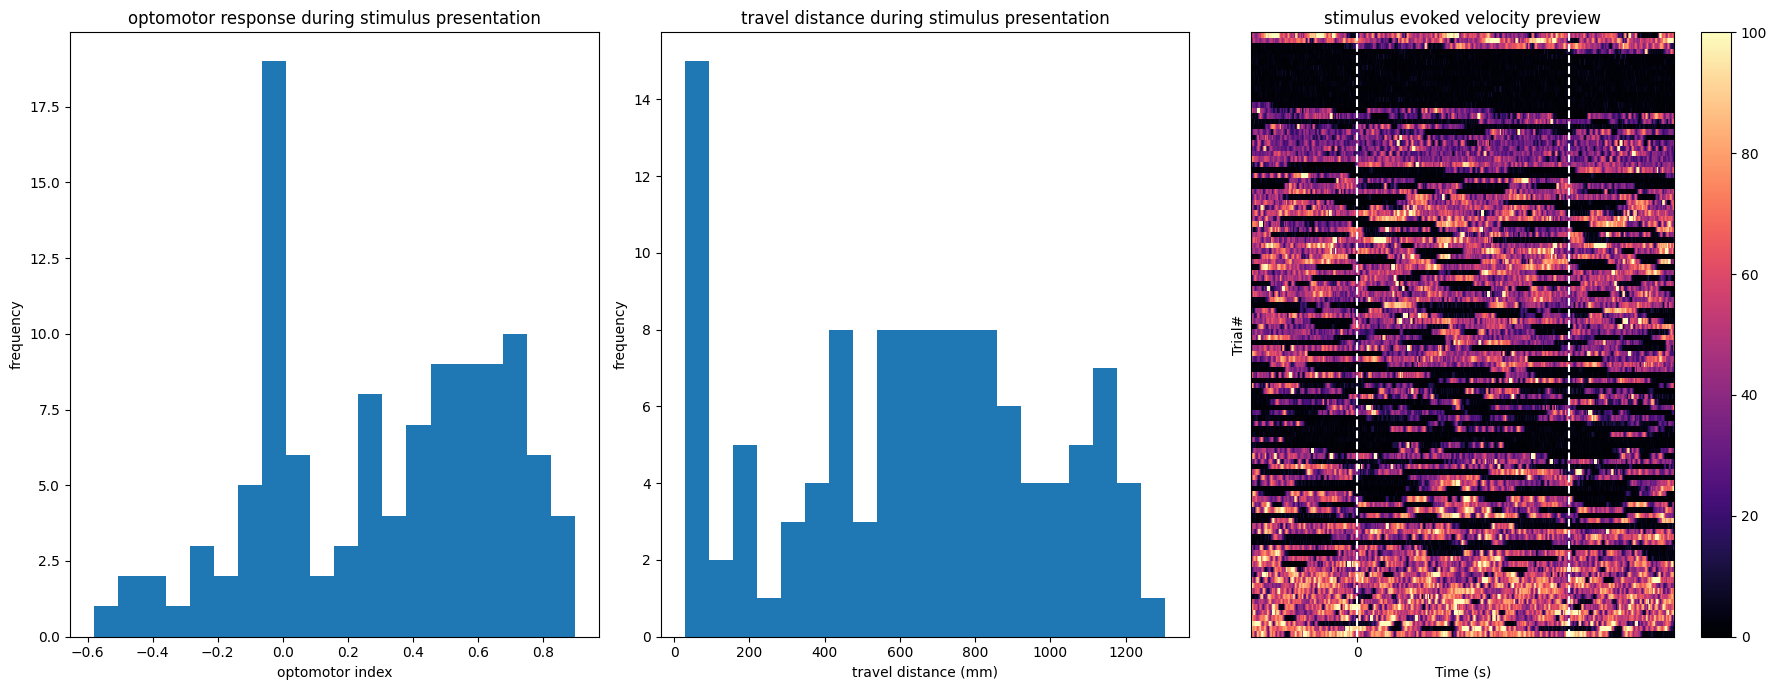

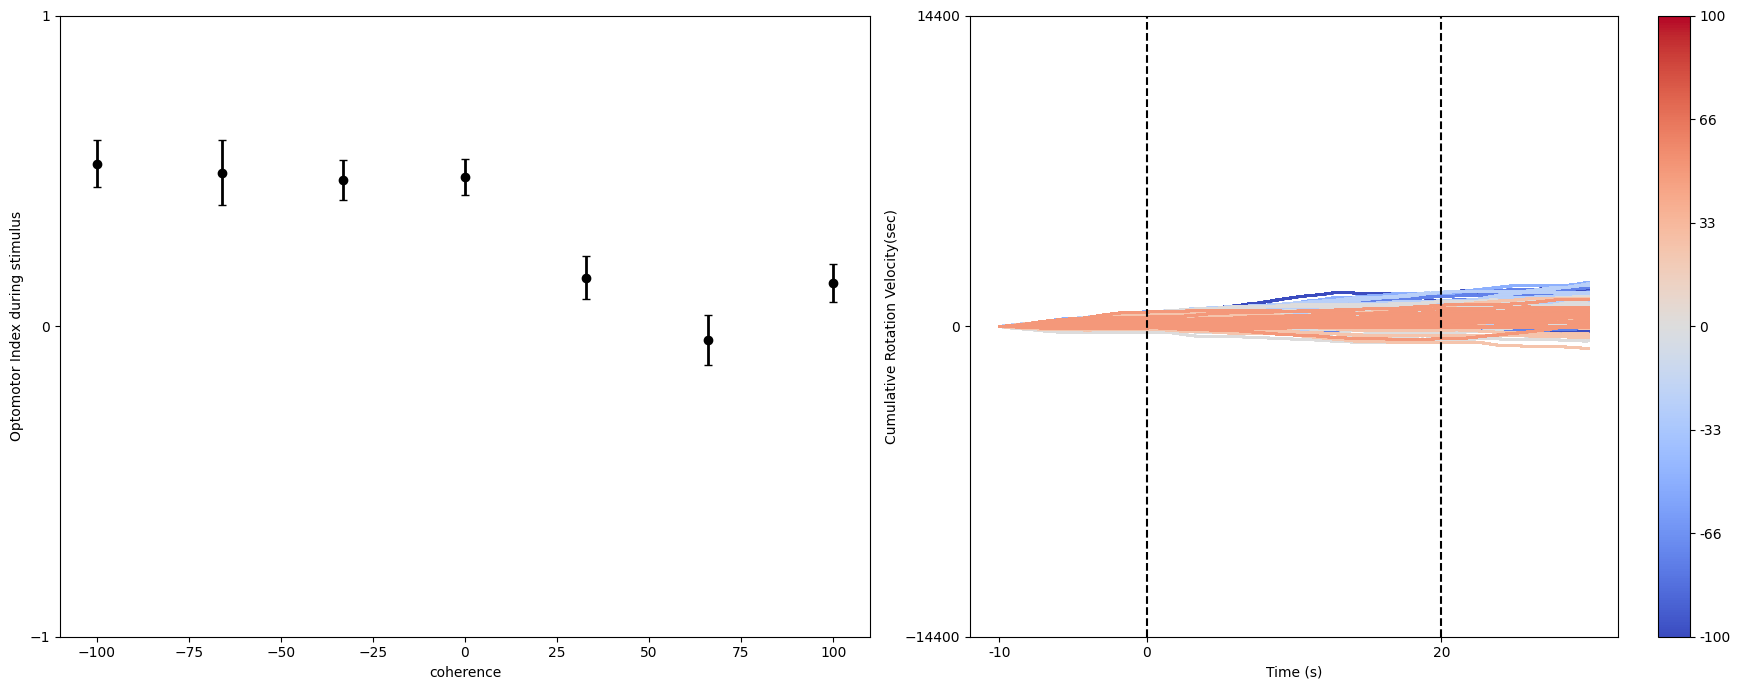

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session3. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session3. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session3. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23011/231125/coherence/session3. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23011\231125\coherence\session3\fictrac2023-11-25T19_52_48.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


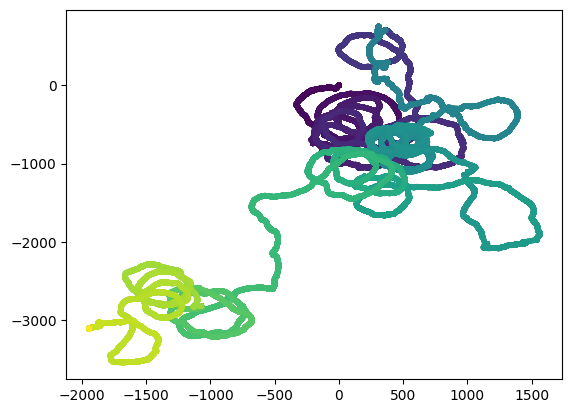

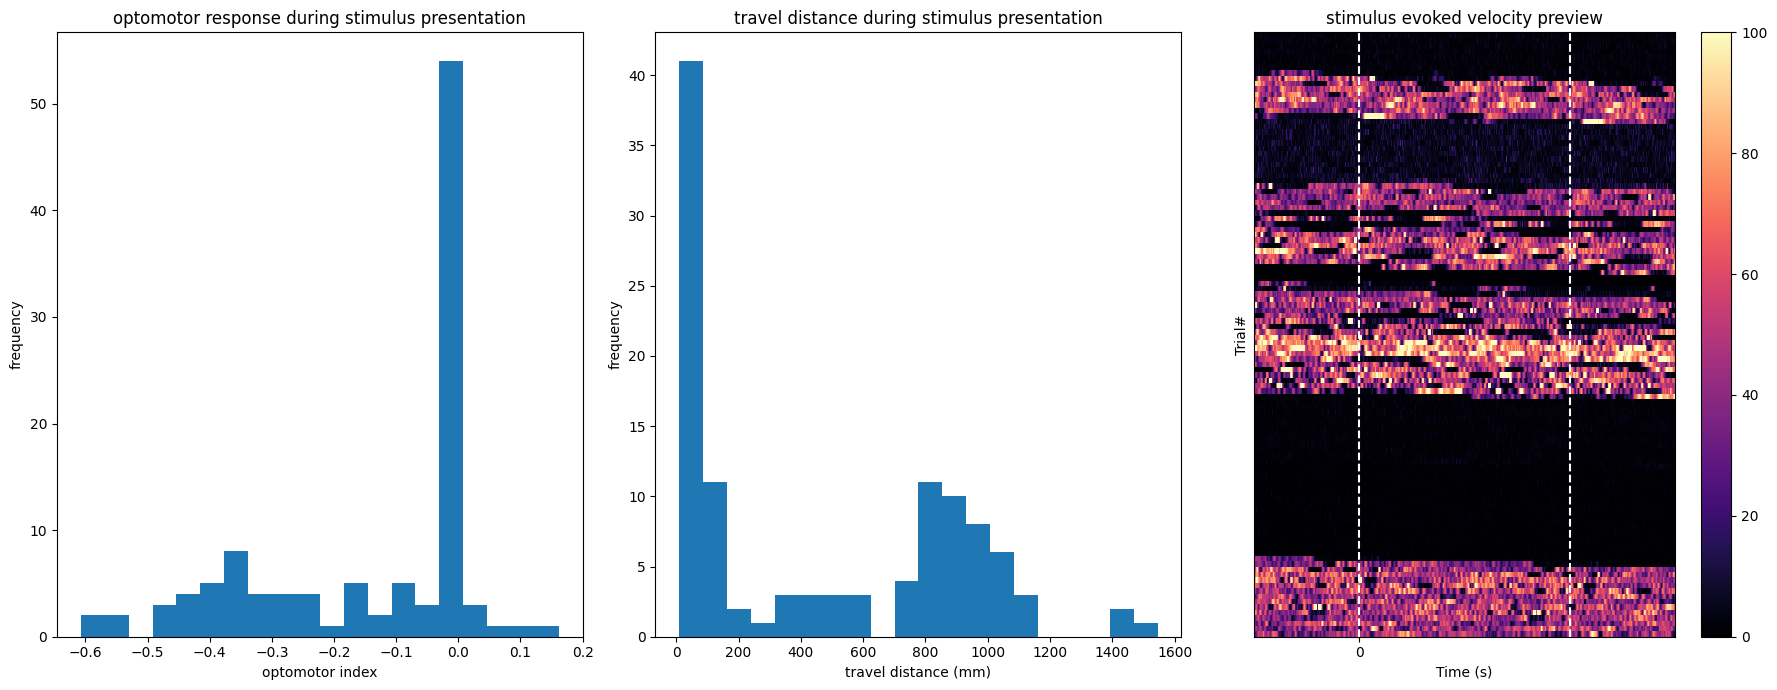

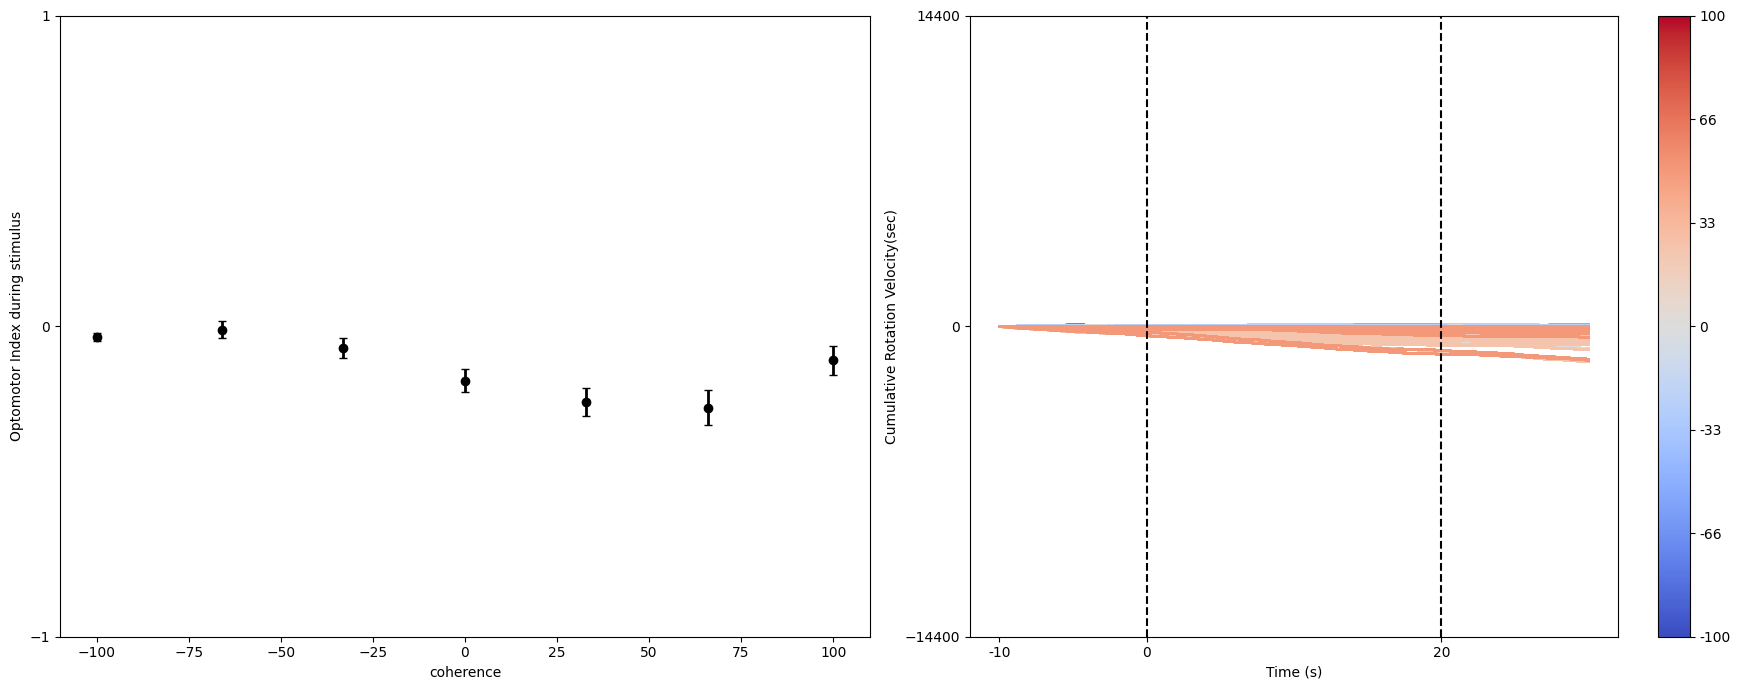

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session1. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session1. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session1. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session1. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23012\231126\coherence\session1\fictrac2023-11-26T13_49_15.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


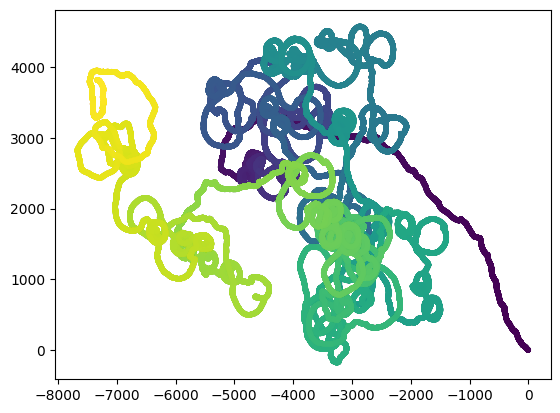

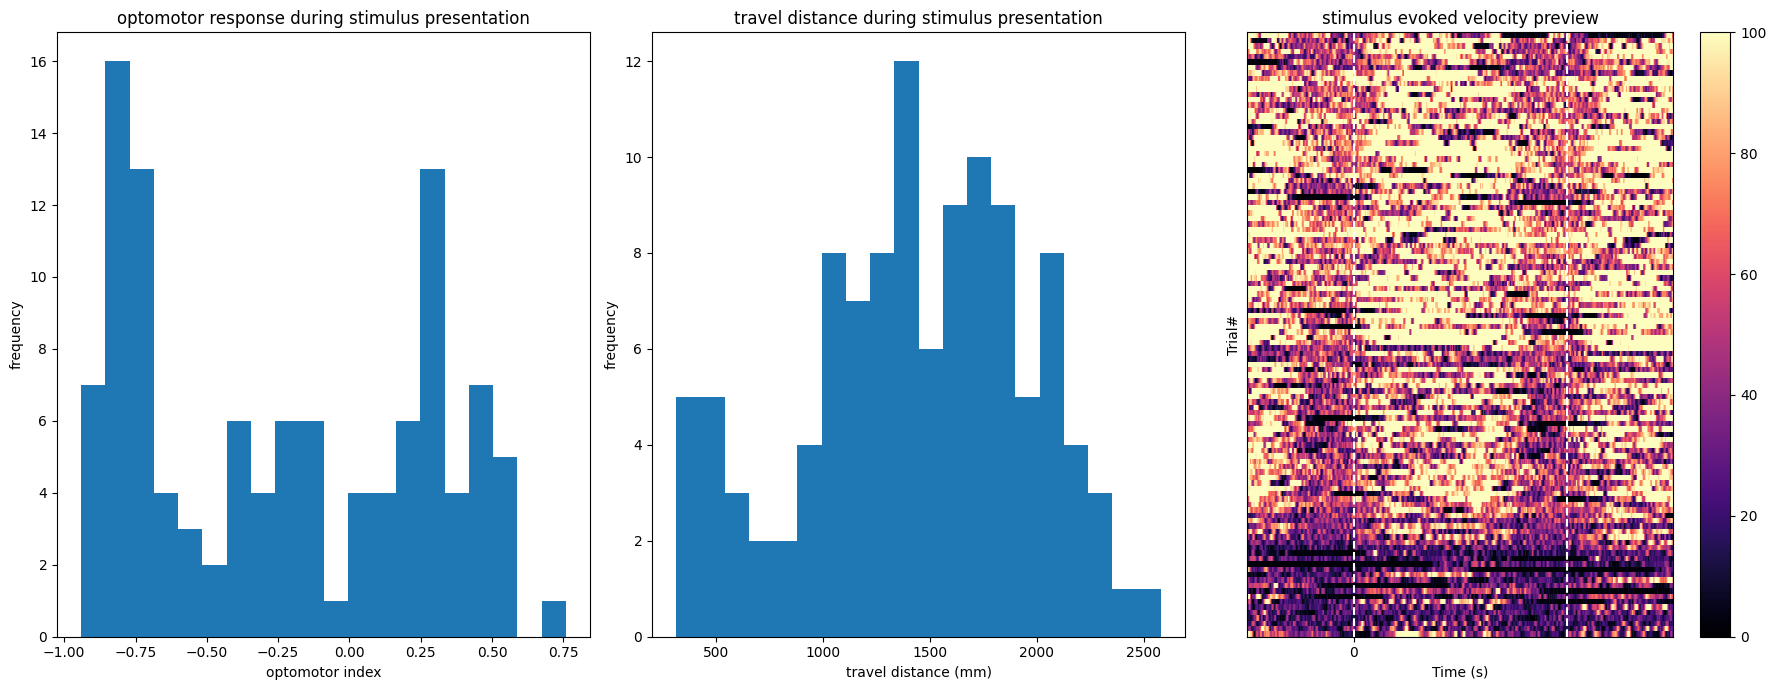

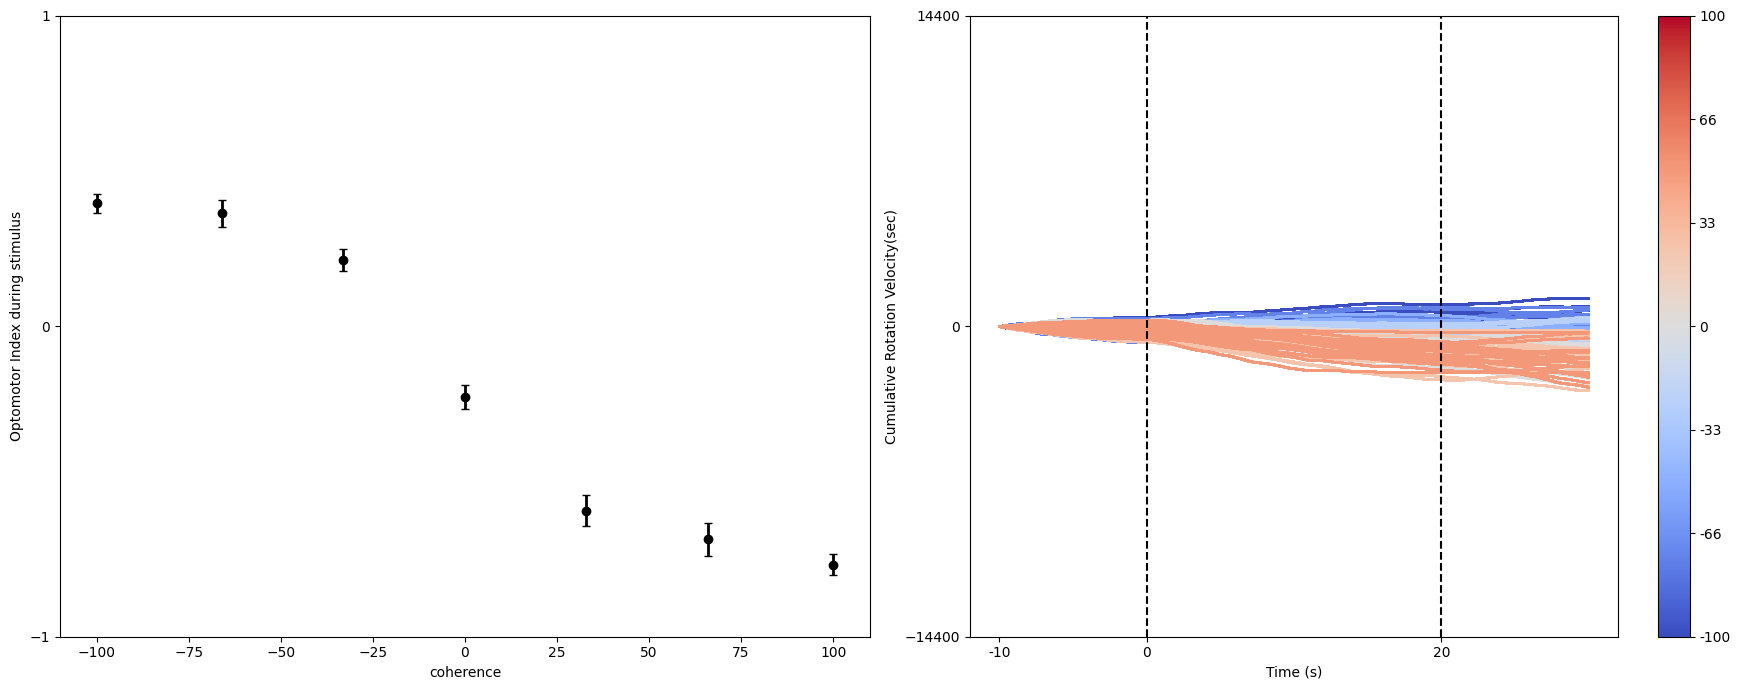

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session2. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session2. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session2. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23012/231126/coherence/session2. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23012\231126\coherence\session2\fictrac2023-11-26T14_56_12.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


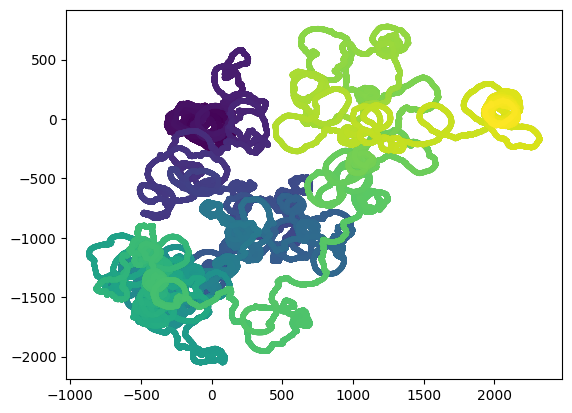

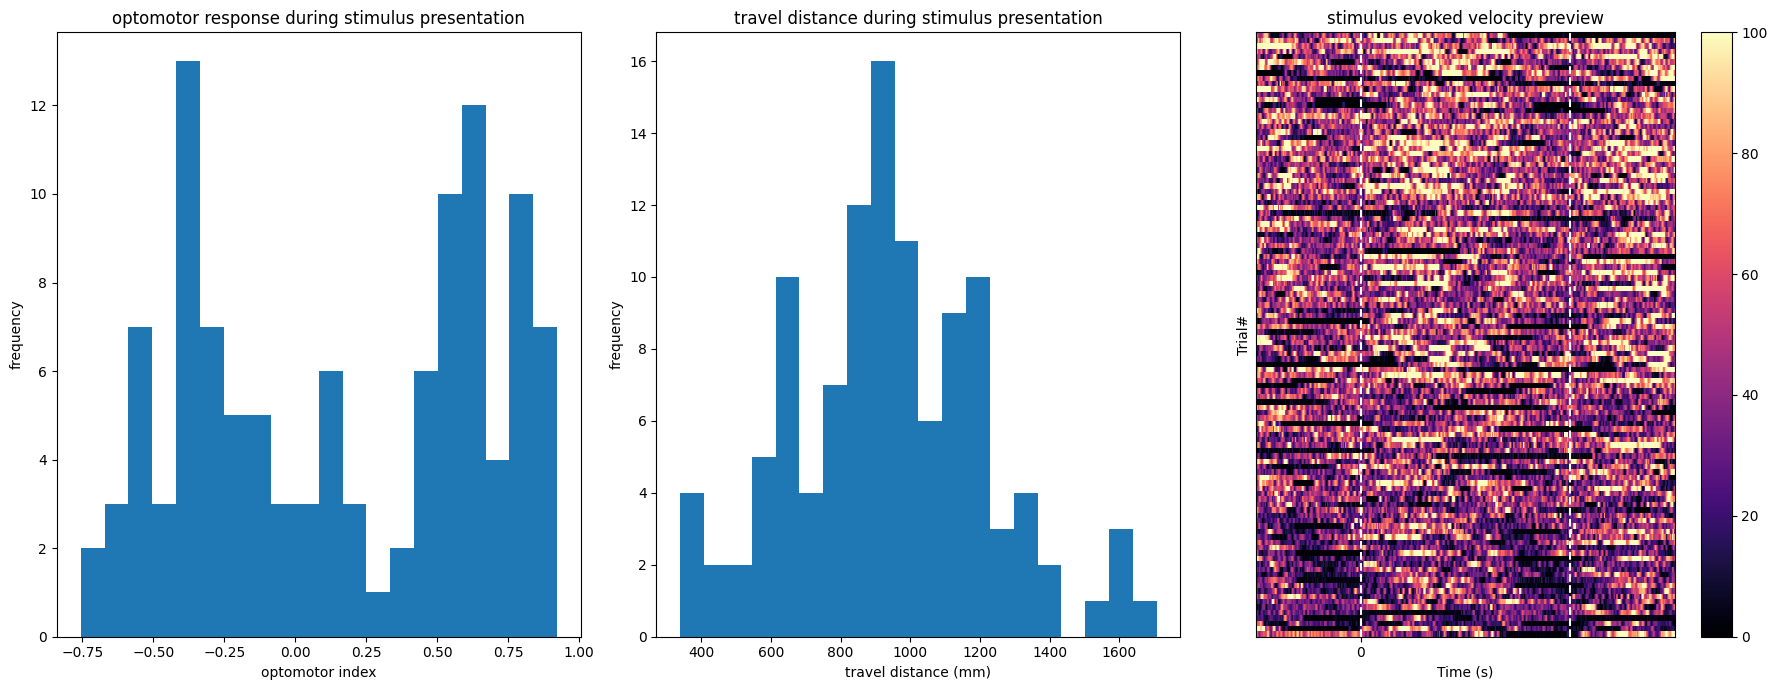

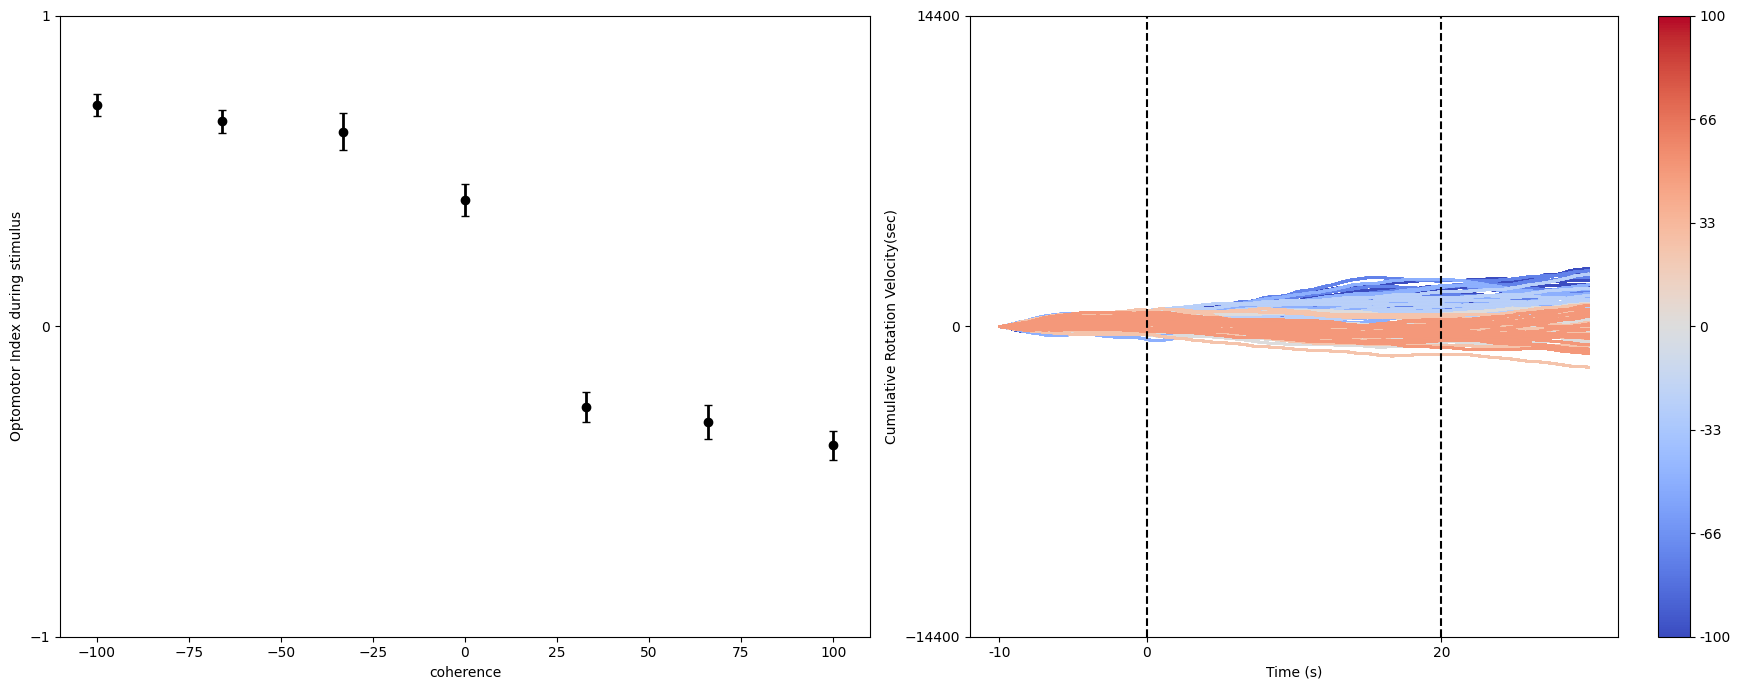

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session1. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session1. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session1. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session1. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23013\231126\coherence\session1\fictrac2023-11-26T16_06_55.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


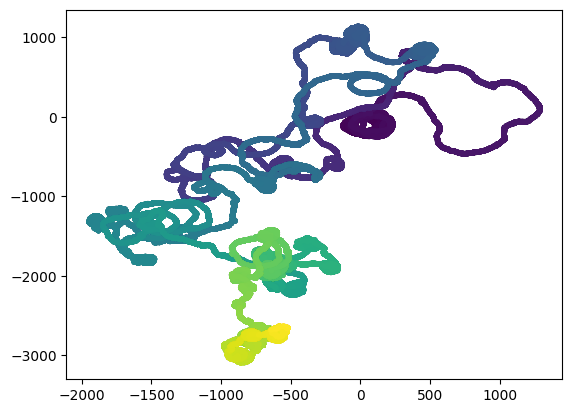

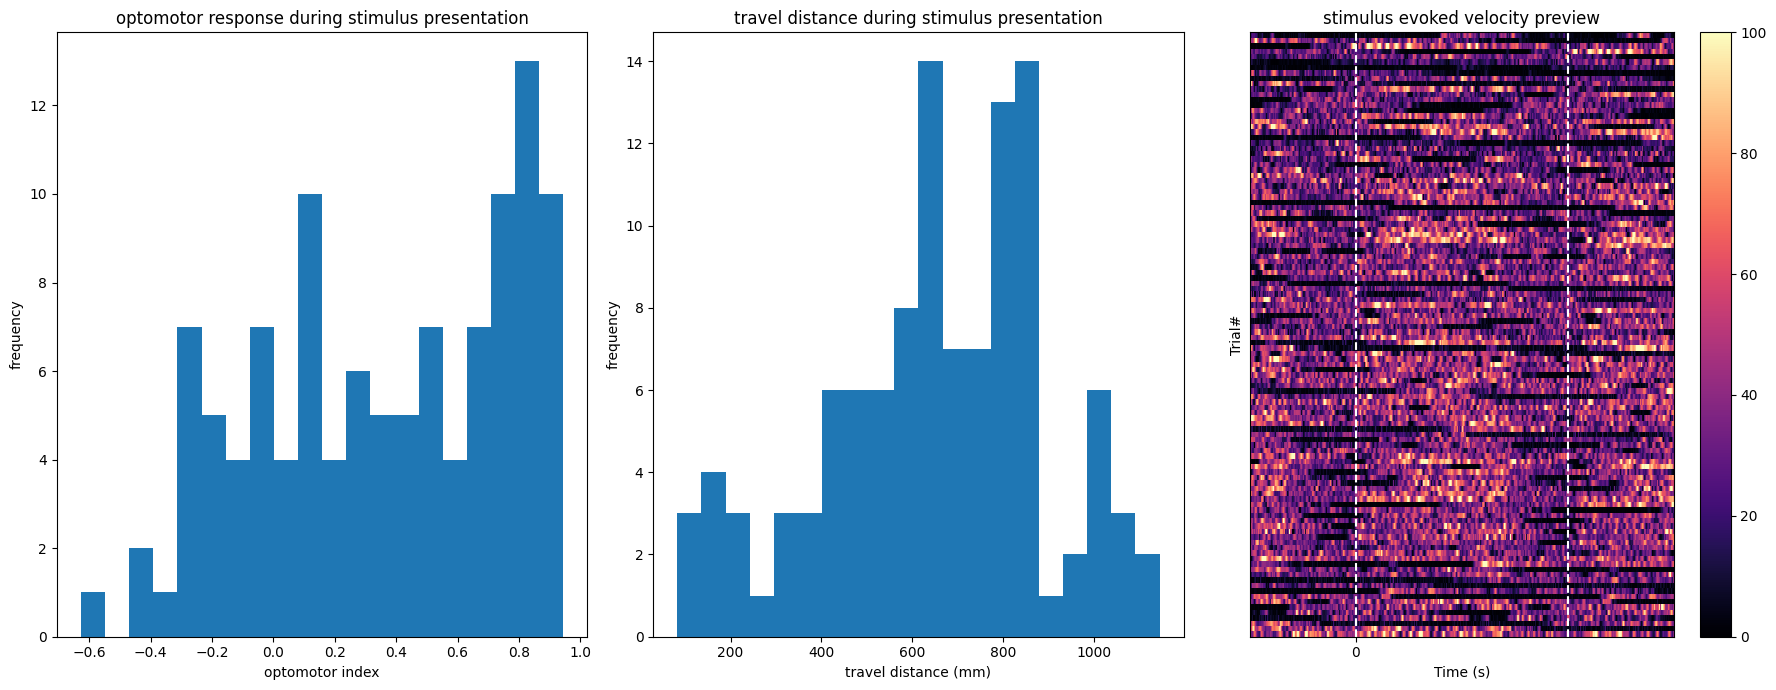

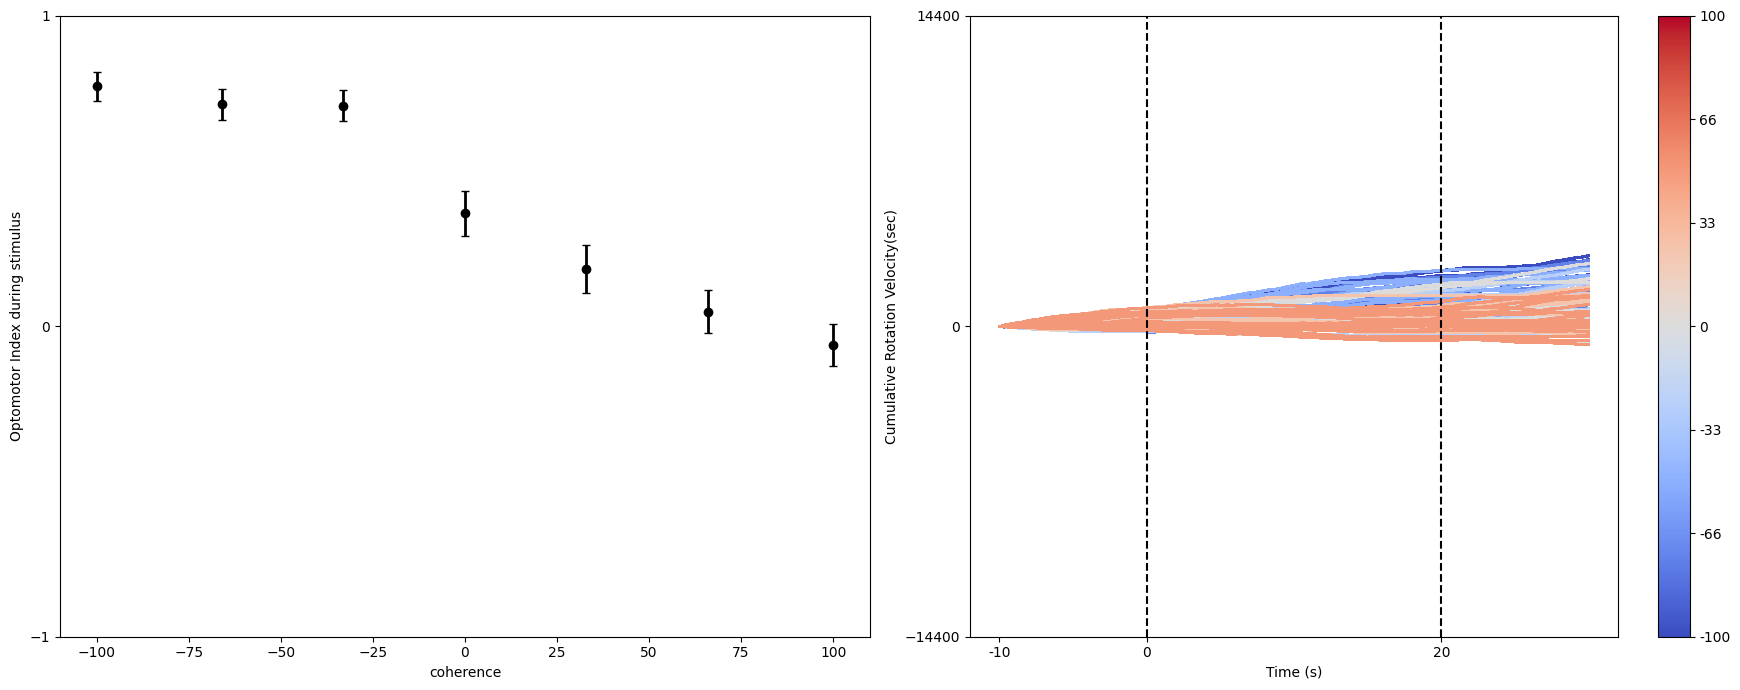

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session2. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session2. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session2. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23013/231126/coherence/session2. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23013\231126\coherence\session2\fictrac2023-11-26T17_10_41.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


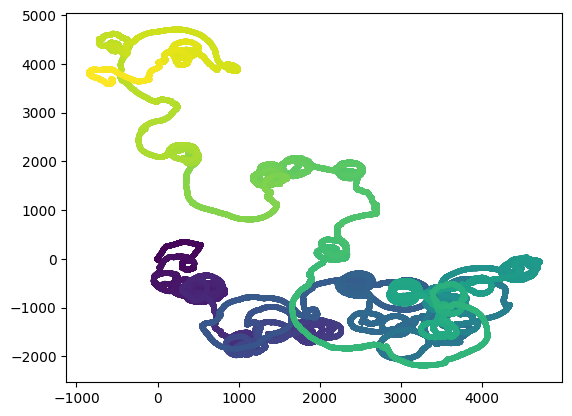

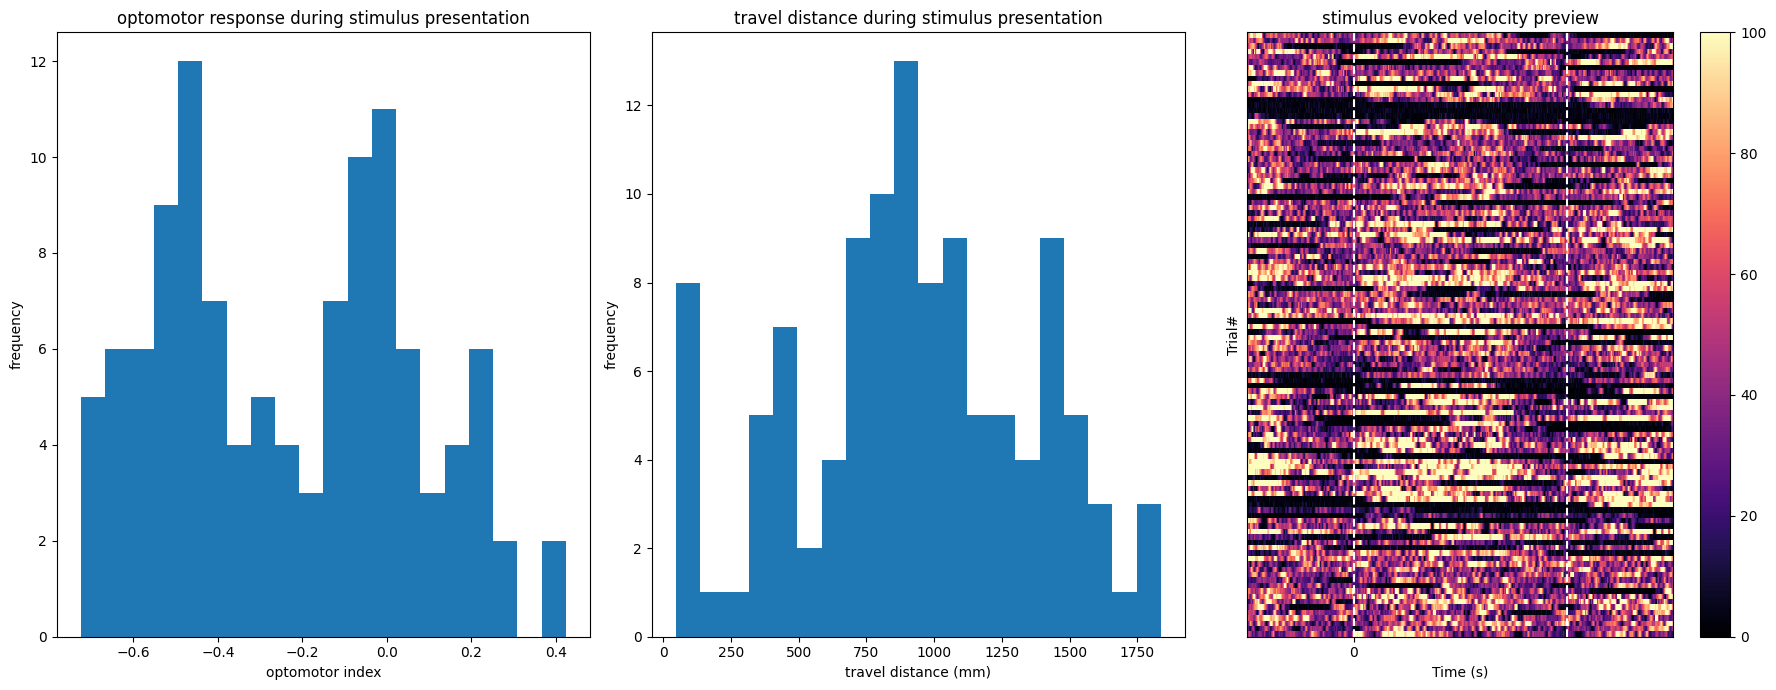

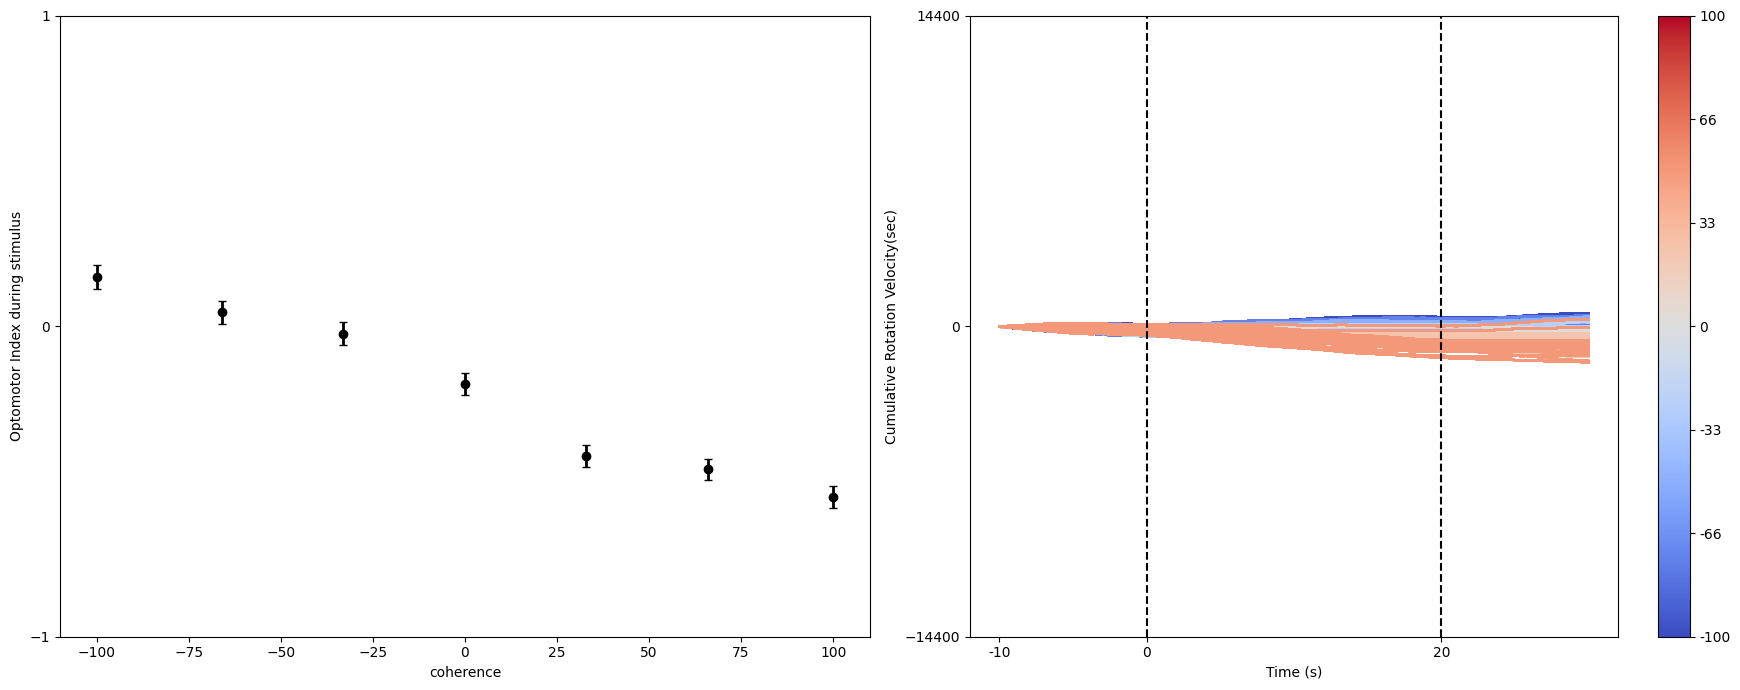

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session1. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session1. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session1. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session1. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23014\231126\coherence\session1\fictrac2023-11-26T18_34_44.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


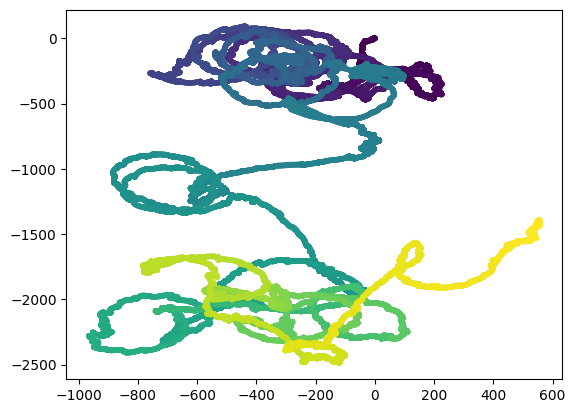

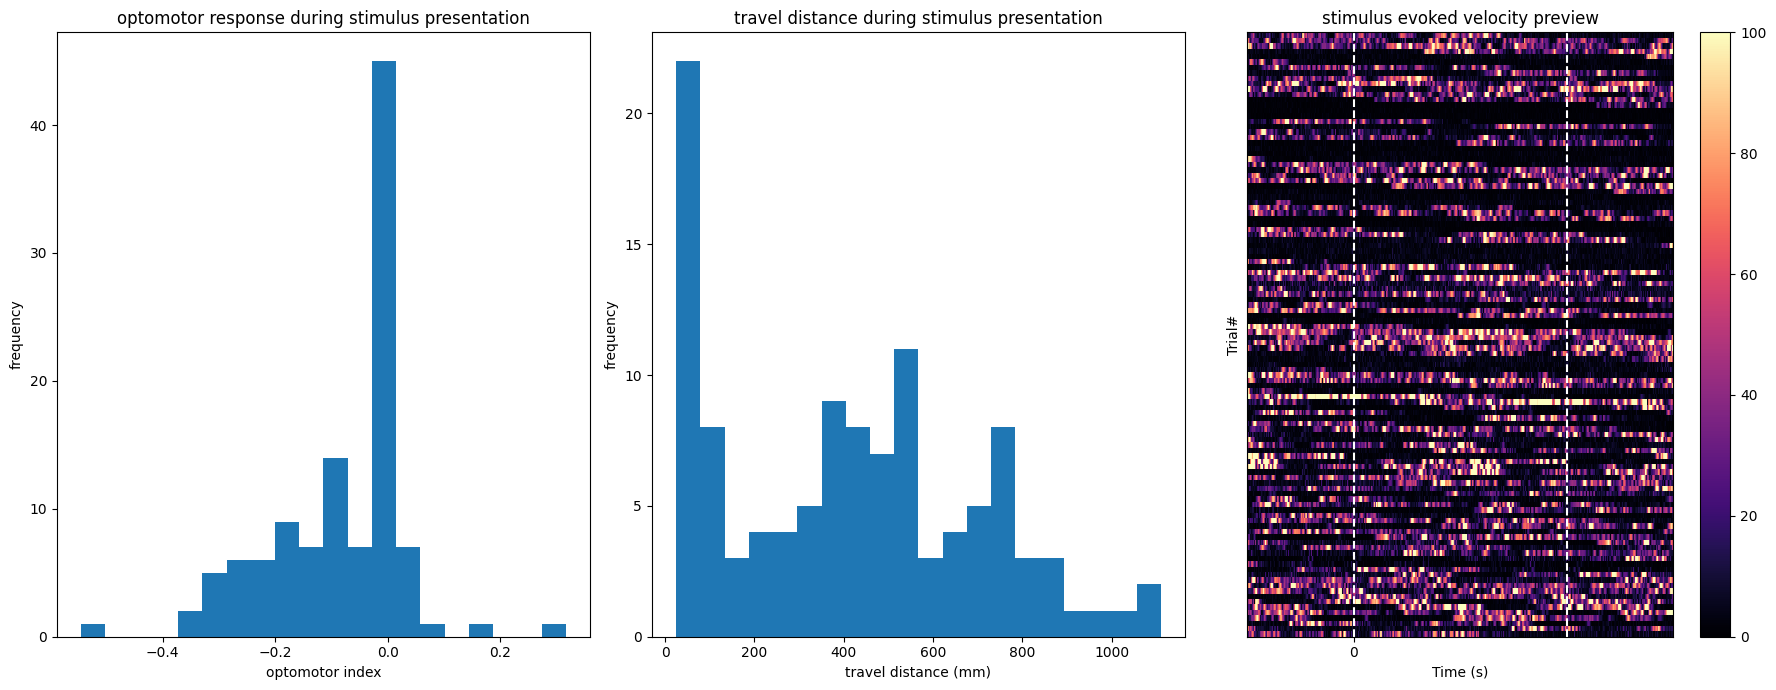

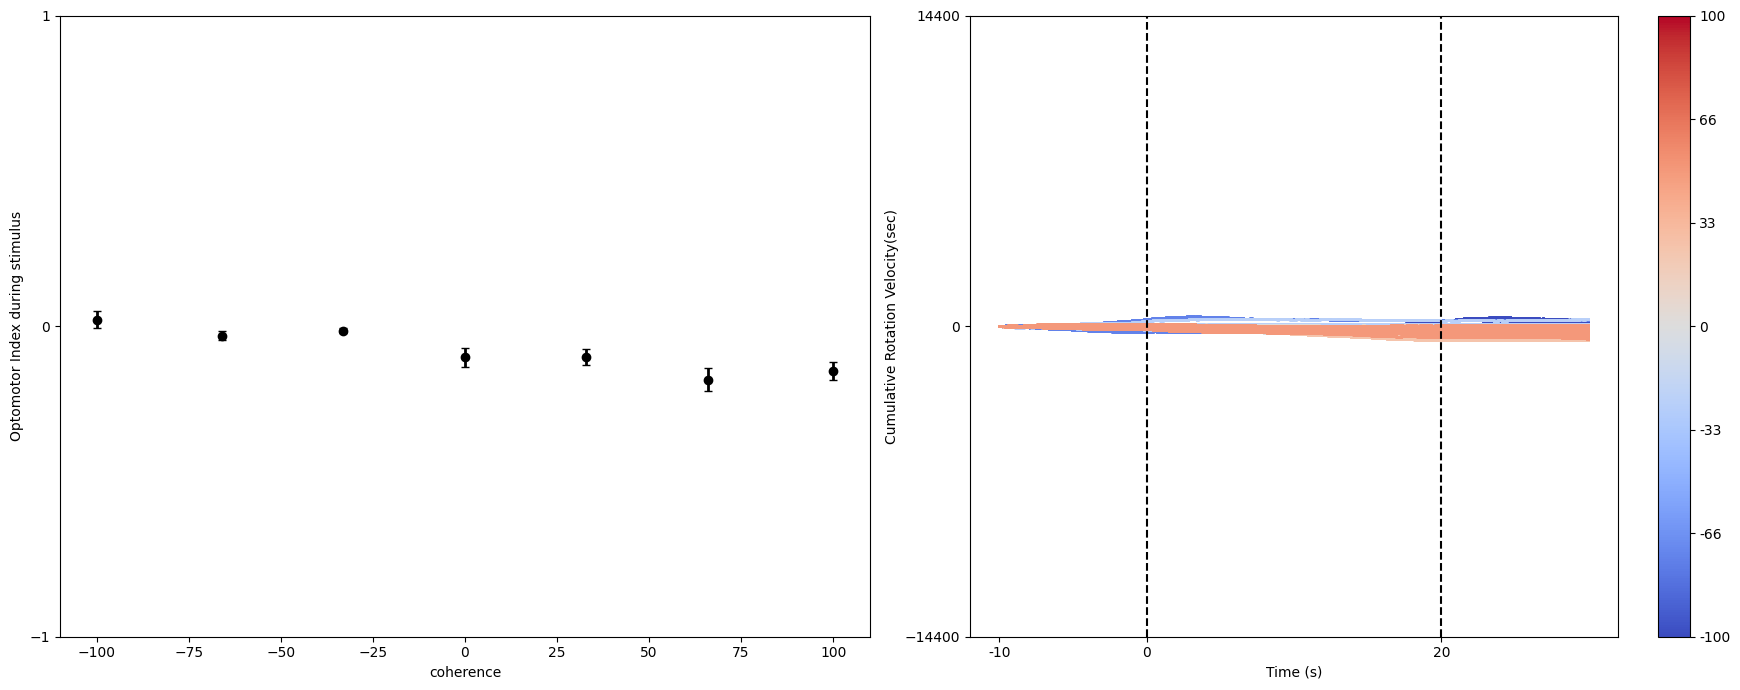

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session2. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session2. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session2. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23014/231126/coherence/session2. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23014\231126\coherence\session2\fictrac2023-11-26T19_39_04.LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


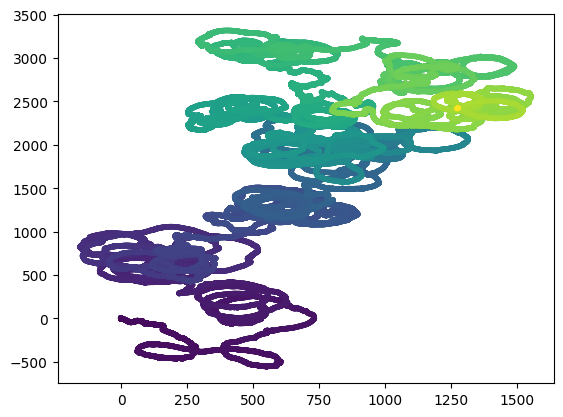

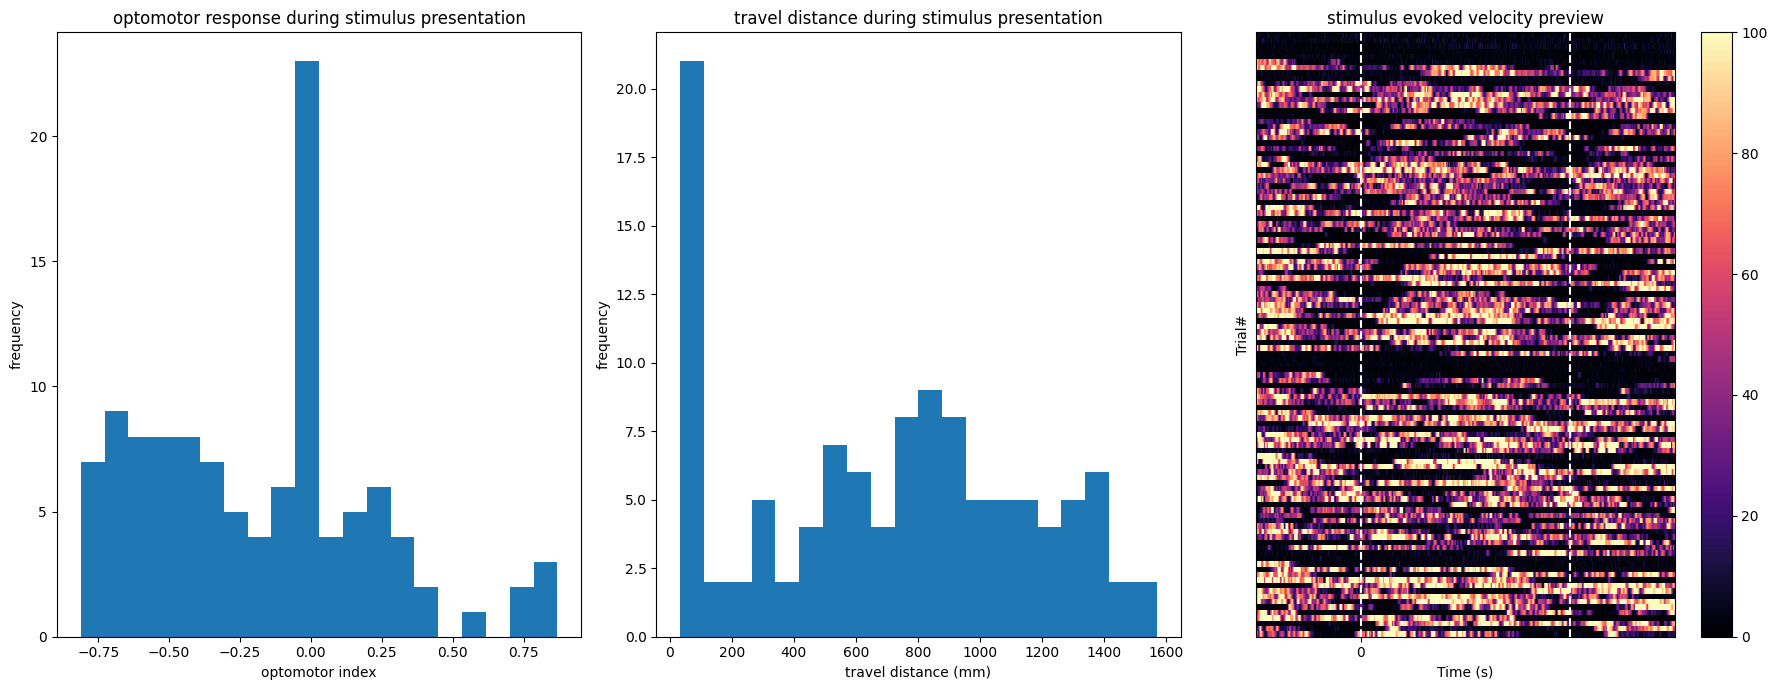

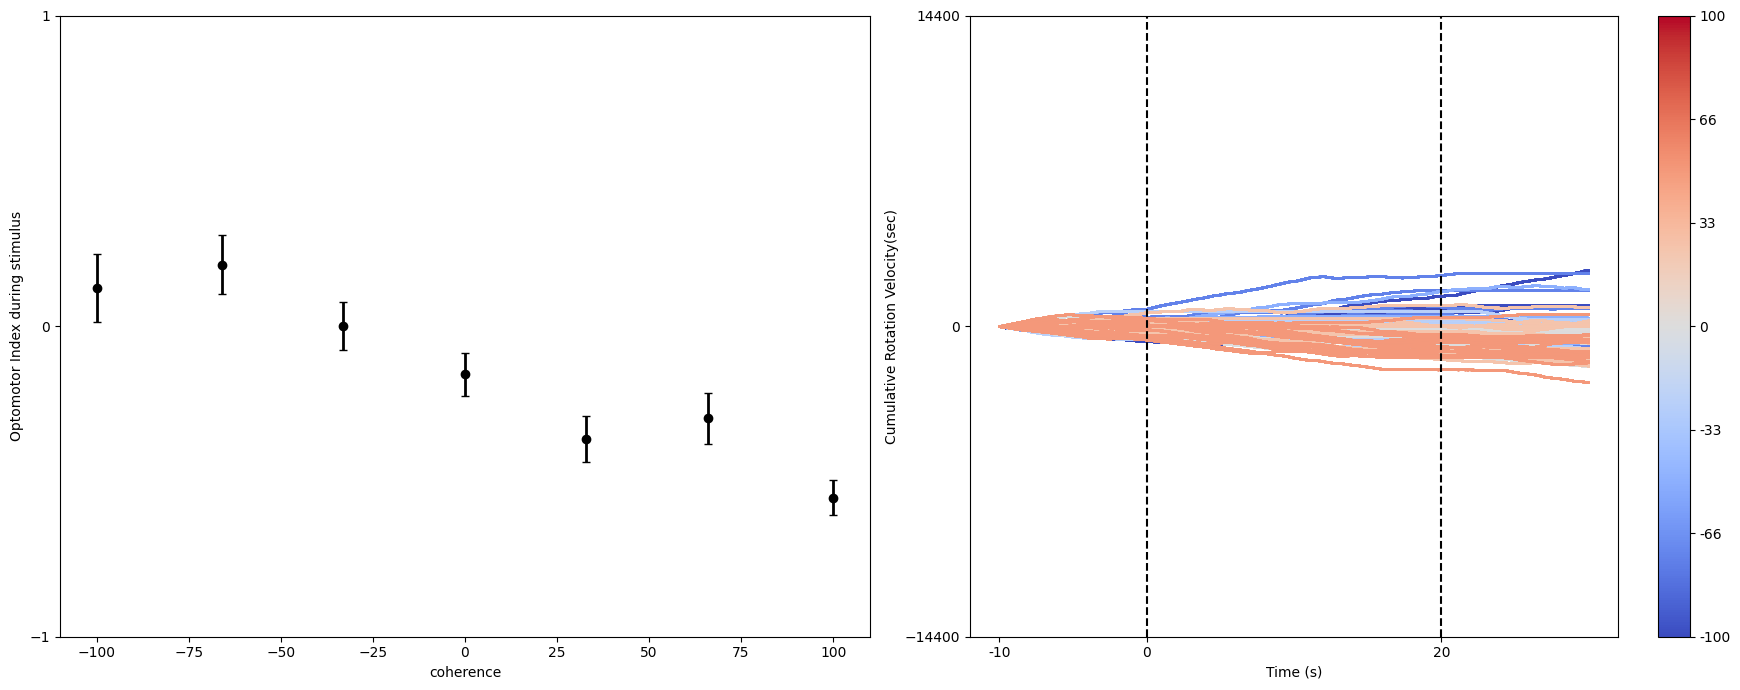

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2. Let's leave this programme
no *sync_pulse.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23018\240422\coherence\session2\camera2_right_top2024-04-22T01_09_54_LED.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


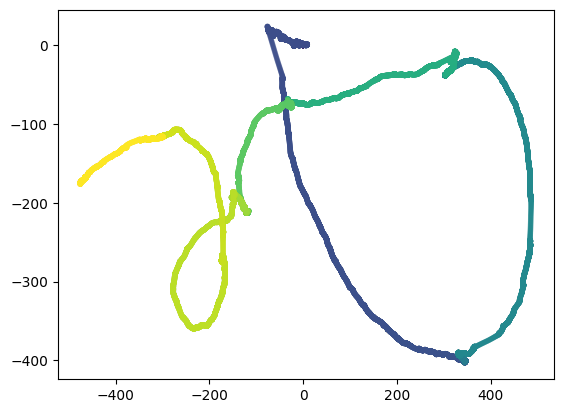

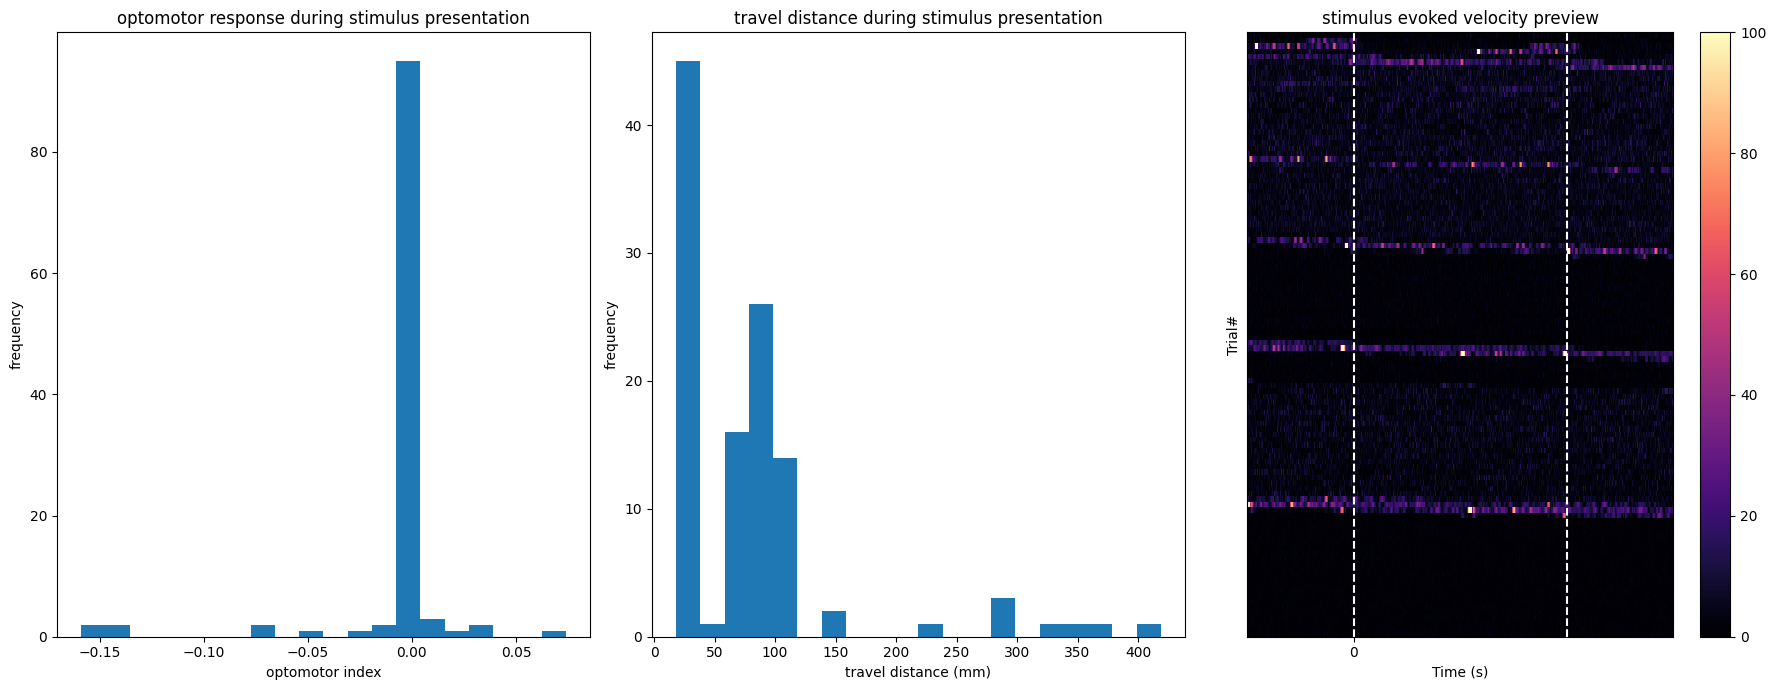

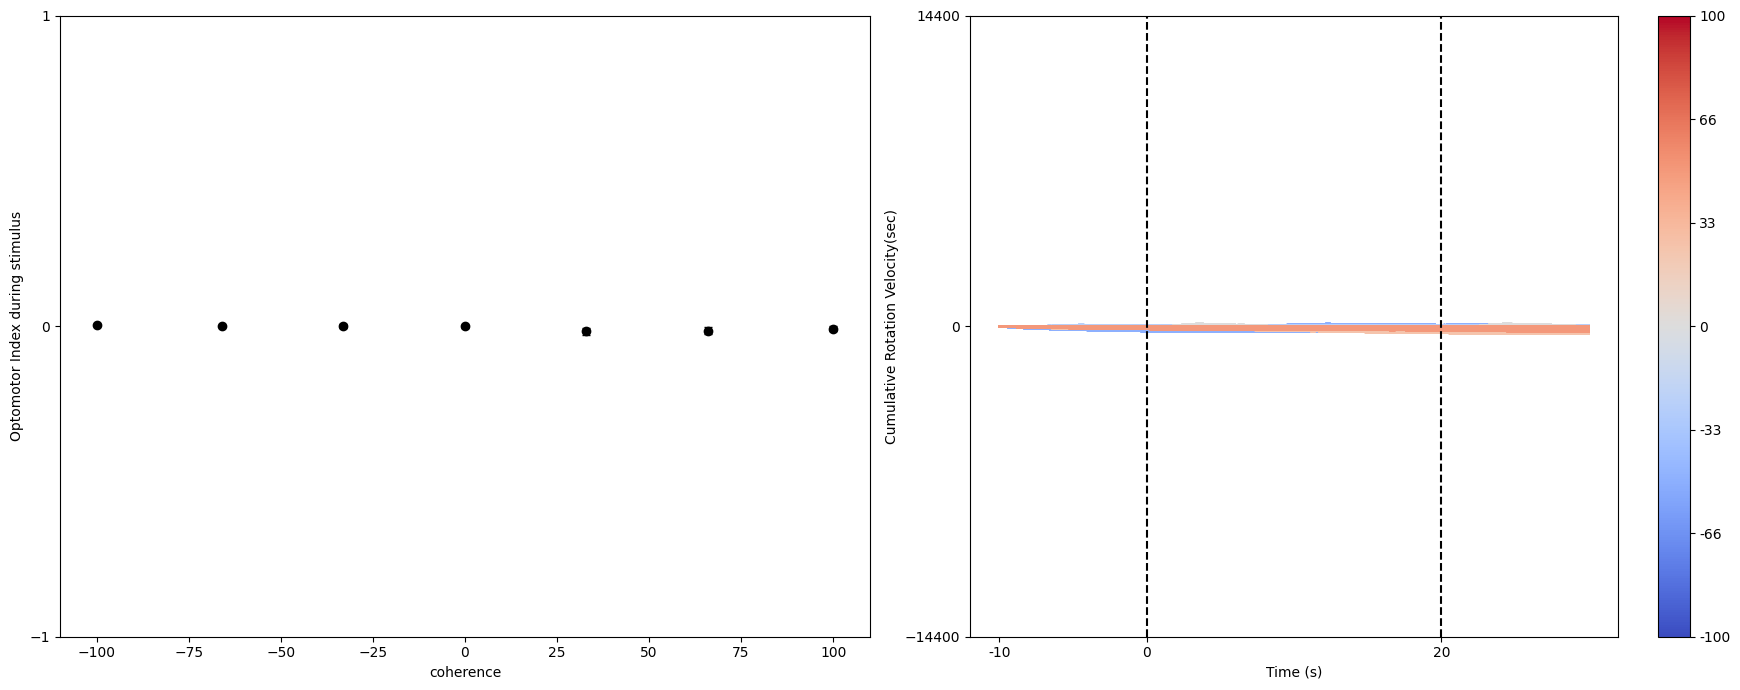

no tracking_*.csv found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1. Let's leave this programme
no *.avi found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1. Let's leave this programme
no fictrac-vidLogFrames*.txt found in Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1. Let's leave this programme
using led file Z:\DATA\experiment_trackball_Optomotor\Zball\GN23019\240507\coherence\session1\camera1_left_top2024-05-07T23_09_31_sync_pulse.csv, extracted from bonsai or elsewhere
plotting data from -10 to 30
classify the behaviour into turning, running, straightwalk, turning_walk + follow and against trials
ready to plot graph with some data and decompose those lists


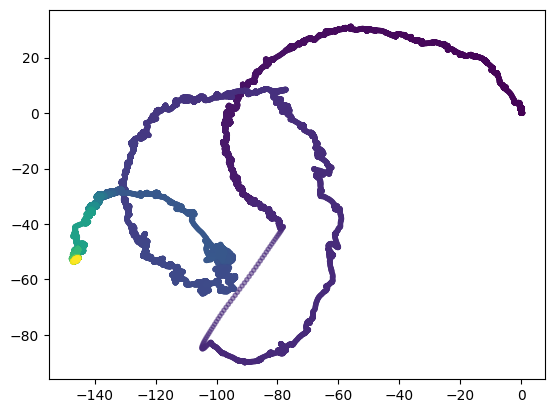

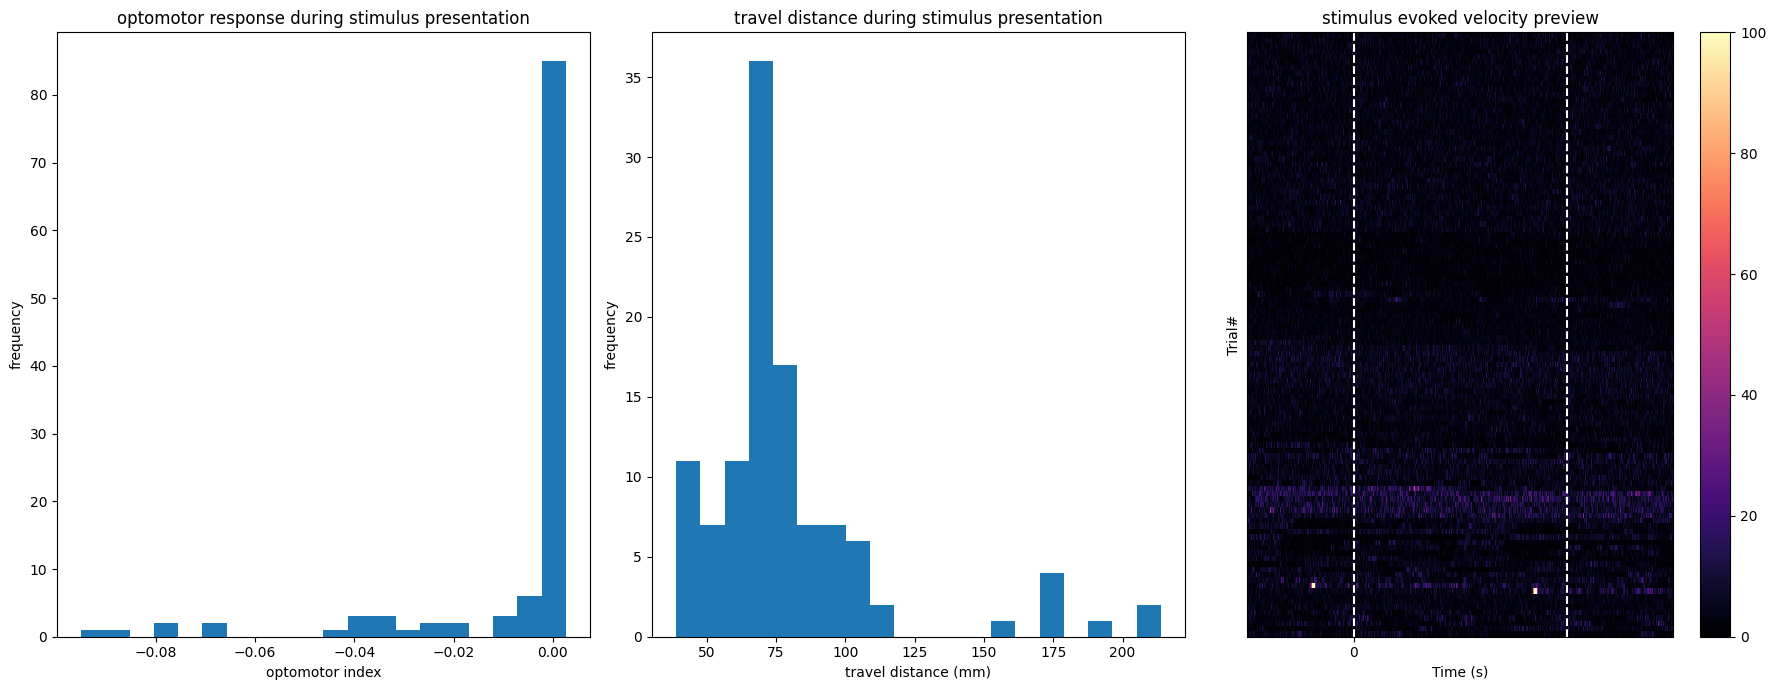

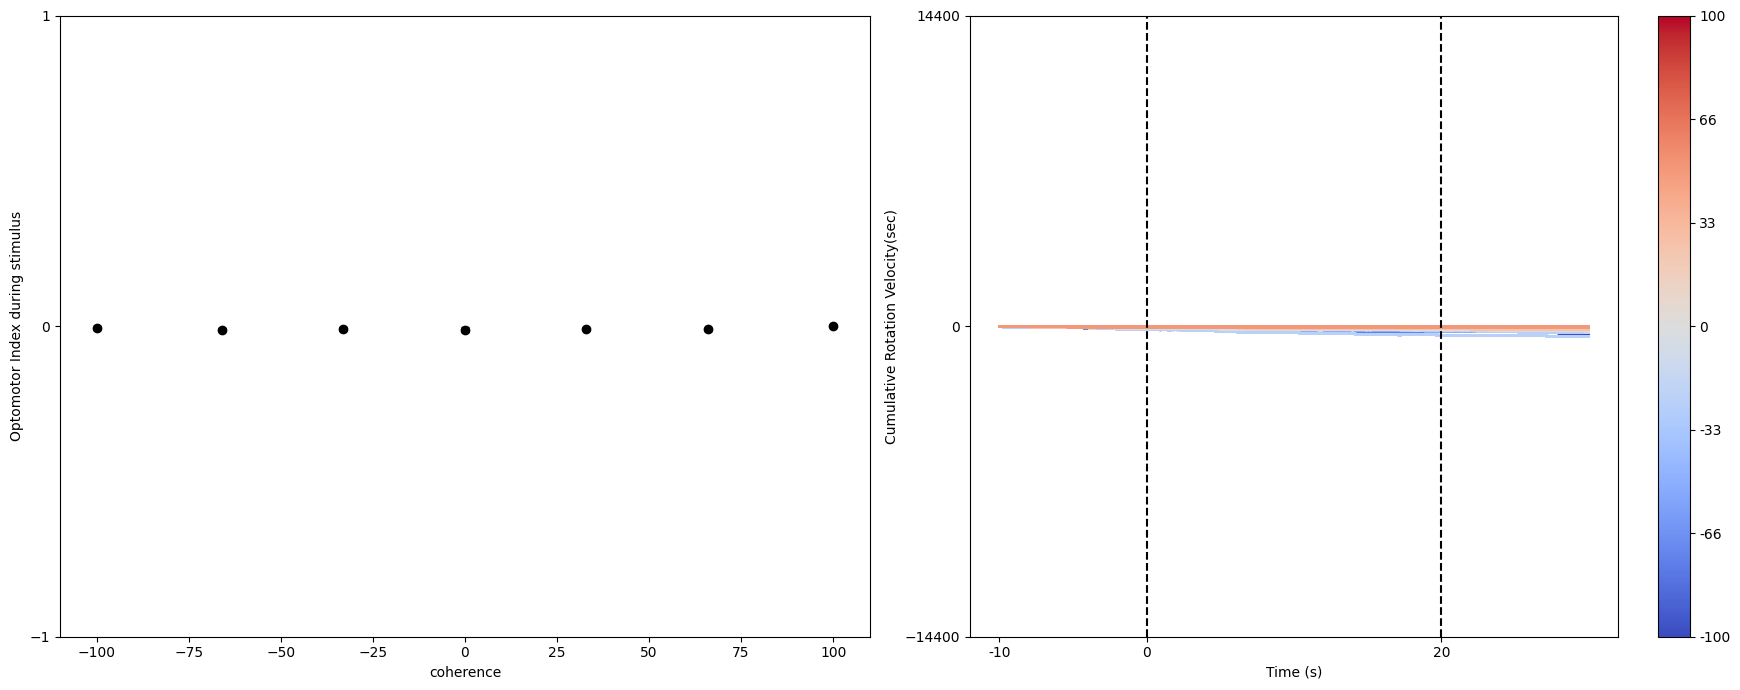

In [6]:
# because the import does not update the new version of python.
# Need to restart kernel 
output0_across_exp=[]
output1_across_exp=[]
output2_across_exp=[]
output3_across_exp=[]
output4_across_exp=[]
for this_dir in dir_list[-10:]:
    if "archive" in this_dir:
        print(f"skip archive folder for {this_dir}")
        continue
    summary,speed,rotation,travel_distance_whole_session=main(this_dir,analysis_methods)
    output0_across_exp.append(summary)
    output1_across_exp.append(speed)
    output2_across_exp.append(rotation)
    output3_across_exp.append(travel_distance_whole_session)
    output4_across_exp.append(this_dir)

Session 2.2: Analyse individual animal's optomotor response with the multi-engines module

In [ ]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(thisDir, analysis_methods):
    from analyse_stimulus_evoked_response import main
    # Check if the H5 file (curated dataset) exists
    summary,speed,rotation = main(thisDir, analysis_methods)
    return (summary,speed,rotation)

# Define analysis_methods

# Use parallel execution to process directories
results = dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

# Initialize result lists
output0_across_exp=[]
output1_across_exp=[]
output2_across_exp=[]

# Collect and organize results
for result in results:
    if result is not None:
        summary,speed,rotation = result
        output0_across_exp.append(summary)
        output1_across_exp.append(speed)
        output2_across_exp.append(rotation)

# Now, you have the results collected in the respective lists

In [ ]:
rc.shutdown()

Session 2.3: plot average behavioural data

In [ ]:
visual_paradigm_name= analysis_methods.get("experiment_name")
colormap = np.array(analysis_methods.get("graph_colour_code"))
fig2, (ax3, ax4) = plt.subplots(
    nrows=1, ncols=2, figsize=(18, 7), tight_layout=True
)
for i in range(len(output0_across_exp)):
    this_animal = output0_across_exp[i]
    tmp=this_animal.groupby("stim_type").count()
    follow_count_coherence = tmp.index.values
    for j in range(len(this_animal.groupby("stim_type"))):
        this_coherence=follow_count_coherence[j]
        this_response = this_animal.loc[
            this_animal["stim_type"] == this_coherence, "opto_index"
        ].values
        # this_coherence = x_axis_value_running_trials[i]
        mean_response = np.mean(this_response, axis=0)
        sem_response = np.std(this_response, axis=0, ddof=1) / np.sqrt(
            this_response.shape[0]
        )
        ax3.errorbar(
            this_coherence,
            mean_response,
            yerr=sem_response,
            c=colormap[5],
            fmt="o",
            elinewidth=2,
            capsize=3,
        )
    ax3.set_ylim(-1, 1)
    ax3.set(
        yticks=[-1, 0, 1],
        ylabel="Optomotor Index",
        xlabel=visual_paradigm_name,)
    # ax4.scatter(follow_count_coherence, follow_count, c=colormap[0], marker="o")
    # ax4.set_ylim(0, 15)
    # ax4.set(
    #     yticks=[0, 15],
    #     ylabel="Follow response (count)",
    #     xticks=[100, 50, 0, -50, -100],
    #     xlabel="Coherence level (%)",
    # )
    ##following one dot (dot lifetime)
    ##memory part (30s)
    ##interval: rondot
    ##continous

Session 3: load ephys data

In [10]:
dir_list = []
file_type=".dat"
for root, dirs, files in os.walk(thisDataset):
    if analysis_methods.get("experiment_name") in root.split(
        os.path.sep
    ):  ## add this condition to avoid data from other experiments
        for folder in dirs:
            if folder.startswith("Record Node"):
                dir_list.append(root.replace("\\", "/"))


print(f"these directories are found {dir_list}")

these directories are found ['Z:/DATA/experiment_trackball_Optomotor/Zball/GN2300x/231123/coherence/2024-05-05_22-57-50', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23015/240201/coherence/session1/2024-02-01_15-25-25', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23016/240201/coherence/session1/2024-02-01_18-55-51', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23017/240409/coherence/session1/2024-04-09_15-57-39', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2/2024-04-22_01-09-50', 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1/2024-05-07_23-08-55']


In [9]:
dir_list

['Z:/DATA/experiment_trackball_Optomotor/Zball/GN2300x/231123/coherence/2024-05-05_22-57-50/Record Node 102',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23015/240201/coherence/session1/2024-02-01_15-25-25/Record Node 102',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23016/240201/coherence/session1/2024-02-01_18-55-51/Record Node 102',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23017/240409/coherence/session1/2024-04-09_15-57-39/Record Node 102',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2/2024-04-22_01-09-50/Record Node 102',
 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1/2024-05-07_23-08-55/Record Node 102']

Session 3.1: create pre-processed dataset and apply an automatic sorter to ephys data

In [19]:
def that_ephys_folder_not_exist(base_directory,pattern):
    for item in os.listdir(base_directory):
        item_path = os.path.join(base_directory, item)
        if os.path.isdir(item_path) and item.startswith(pattern):
            return False
    return True

In [20]:
folder_name_start_from="sorting"
for this_dir in dir_list:
    if that_ephys_folder_not_exist(this_dir,folder_name_start_from):
        print(f"The directory '{this_dir}' does not contain any folders starting with {folder_name_start_from}.")
        #raw2si(this_dir,json_file)
    else:
        print(f"The directory '{this_dir}' contains at least one folder starting with {folder_name_start_from}.")


The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN2300x/231123/coherence/2024-05-05_22-57-50' does not contain any folders starting with sorting.
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23015/240201/coherence/session1/2024-02-01_15-25-25' contains at least one folder starting with sorting.
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23016/240201/coherence/session1/2024-02-01_18-55-51' contains at least one folder starting with sorting.
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23017/240409/coherence/session1/2024-04-09_15-57-39' contains at least one folder starting with sorting.
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/session2/2024-04-22_01-09-50' contains at least one folder starting with sorting.
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23019/240507/coherence/session1/2024-05-07_23-08-55' does not contain any folders starting with sorting.


Session 3.2: spike sorting curation and create spike analyser as a database

In [22]:
for this_dir in dir_list:
    if that_ephys_folder_not_exist(this_dir,"phy"):
        print(f"The directory '{this_dir}' does not contain any folders starting with phy. That means the manual curation process is not done")
        #spike_curation(this_dir,json_file)
    elif that_ephys_folder_not_exist(this_dir,"analyser"):
        print(f"The directory '{this_dir}' does not contain any folders starting with analyser. That means the curated data has not been process with anlayser yet")
    else:
        print(f"The directory '{this_dir}' have both folders. Hence it is ready to move on to the next session.")
        #decode_spikes(this_dir,json_file)


The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN2300x/231123/coherence/2024-05-05_22-57-50' does not contain any folders starting with phy. That means the manual curation process is not done
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23015/240201/coherence/session1/2024-02-01_15-25-25' does not contain any folders starting with analyser. That means the curated data has not been process with anlayser yet
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23016/240201/coherence/session1/2024-02-01_18-55-51' does not contain any folders starting with analyser. That means the curated data has not been process with anlayser yet
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23017/240409/coherence/session1/2024-04-09_15-57-39' does not contain any folders starting with analyser. That means the curated data has not been process with anlayser yet
The directory 'Z:/DATA/experiment_trackball_Optomotor/Zball/GN23018/240422/coherence/sessi

Session 3.3: Sync ephys data with other datasets so that we can plot spike rate in response to the onset of certain events